# **Image Classifier with PyTorch**

# 0. Set Up

For this tutorial, we will be using ``numpy`` to generate data and all operations, ``matplotlib`` to render and plot images and of course ``nets`` for ``Tensor`` operations and computational graph creation. We will set the ``SEED`` for random numbers from ``numpy``, so each time we reload the notebook the results will be the same as numbers will be generated in the same way. Finally, we set an autoreload with ``%load_ext autoreload`` and ``%autoreload 2`` for debug mode purposes. This enable the notebook to reload the modules each time we run a cell, so it keeps everything up-to-date. More info [on StackOverflow](http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython).

Let's load the packages we need to run our tests:

In [1]:
import numpy as np
import random as rd
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.style.use('seaborn-darkgrid')
# Change the font ?
font = {'size'   : 15}
plt.rc('font', **font)

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
# Let's fix the seed

SEED = 42
rd.seed(SEED)
np.random.seed(SEED)

# 1. Import the Dataset

In [1]:
import numpy as np
import random as rd
import torch
import torchvision
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

# Normalize the data !
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

# Download the dataset on the default 'root' folder, '.data'
root = '.data'
train_data = datasets.MNIST(root, download=True, train=True, transform=transform)
test_data = datasets.MNIST(root, download=True, train=False, transform=transform)

Extracting .data\MNIST\raw\train-images-idx3-ubyte.gz to .data\MNIST\raw


Extracting .data\MNIST\raw\train-labels-idx1-ubyte.gz to .data\MNIST\raw


Extracting .data\MNIST\raw\t10k-images-idx3-ubyte.gz to .data\MNIST\raw


Extracting .data\MNIST\raw\t10k-labels-idx1-ubyte.gz to .data\MNIST\raw
Processing...
Done!


# 2. Load the data

In [2]:
print('Sanity Check')
print(train_data.data.shape)
print(train_data.targets.shape)

BATCH_SIZE = 64
train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)

Sanity Check
torch.Size([60000, 28, 28])
torch.Size([60000])


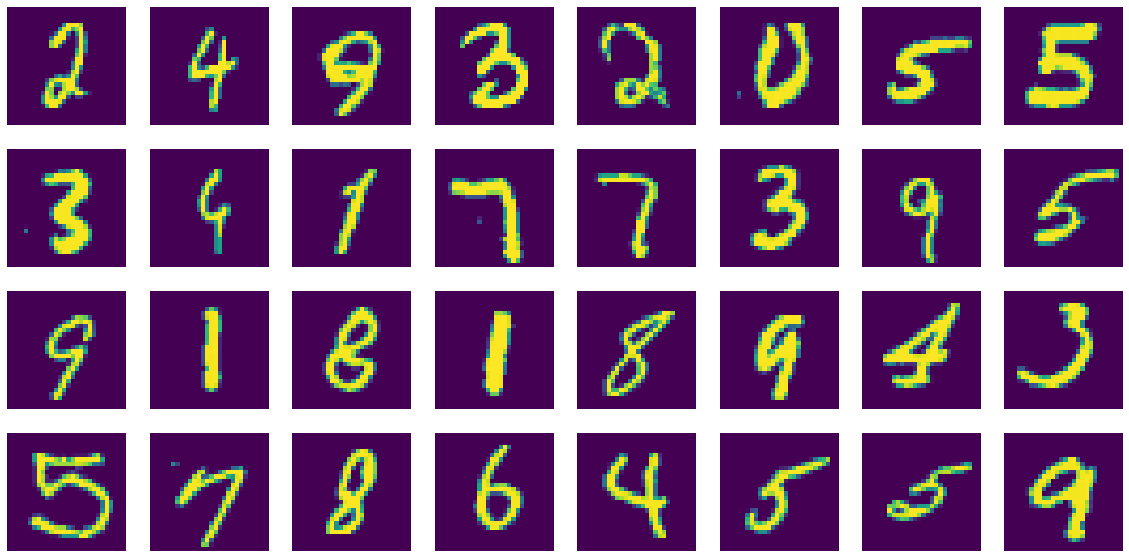

In [3]:
# Configure the mosaic to display images
fig = plt.figure(figsize = (20, 10))
columns = 8
rows = 4

# Create the mosaic
for i in range(1, columns * rows + 1):
    
    # Choose randomly an image
    image_index = rd.randint(0, len(train_data))
    image, label = train_data.data[image_index], train_data.targets[image_index]
    
    # Plot one image in the grid
    fig.add_subplot(rows, columns, i)
    plt.imshow(image.numpy().reshape(28, 28))
    
    #Remove axis
    plt.axis('off')
    
# Render
plt.show()

# 3. Build a model

In [4]:
import torch.nn as nn

# Just a simple model
class Classifier(nn.Module):

    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.layer1 = nn.Linear(input_dim, hidden_dim)
        self.layer2 = nn.Linear(hidden_dim, hidden_dim)
        self.layer3 = nn.Linear(hidden_dim, output_dim)

    def forward(self, inputs):
        out1 = nn.functional.relu(self.layer1(inputs))
        out2 = nn.functional.relu(self.layer2(out1))
        return self.layer3(out2)
    
model = Classifier(784, 100, 10)

# Let's check the architecture
model

Classifier(
  (layer1): Linear(in_features=784, out_features=100, bias=True)
  (layer2): Linear(in_features=100, out_features=100, bias=True)
  (layer3): Linear(in_features=100, out_features=10, bias=True)
)

# 4. Criterion & Optimizer

In [5]:
from torch.optim import SGD
from torch.nn import CrossEntropyLoss
from nets.nn.utils import one_hot

# How much do we update the parameters
LEARNING_RATE = 0.01

optimizer = SGD(model.parameters(), lr=LEARNING_RATE)
criterion = CrossEntropyLoss()

# 5. Training

In [7]:
import time
from nets.utils import progress_bar

# Training iterations
EPOCHS = 50

#Display the time during training
start = time.time()
# Record the loss
history = []

# Run the simulation EPOCHS times
for epoch in range(EPOCHS):
    
    # Keep track of the loss at each epoch
    epoch_loss = 0.0
    epoch_start = time.time()
    
    # Number of batches
    N  = len(train_loader)

    # Predict for all batches
    for idx, batch in enumerate(train_loader):
        
        # Gradients accumulates, therefore we need to set them to zero at each iteration
        model.zero_grad()
        
        # Get the images and labels from one batch
        image, label = batch
        # Let's not forget to reshape the images from (BATCH_SIE, 1, 28, 28) to (BATCH_SIZE, 1 * 28 * 28)
        image = image.reshape(-1, 784)
        
        # Run the forward pass by calling the model on our images
        predictions = model(image.float())
        # Get our loss ie how far our predictions are from reality
        loss = criterion(predictions, label.long())
        
        # Compute the gradient
        loss.backward()
        # Update the parameters
        optimizer.step()
        
        # Record the loss for plotting
        epoch_loss += loss.item()
        # Let's plot a progress bar in the console
        progress_bar(idx, N-1, "Training:")
    
    # Update the history of all previous loss
    history.append(epoch_loss / N)
    
    # Check the mean loss for this loop
    print(f"epoch: {epoch}/{EPOCHS} | loss: {epoch_loss / N:1.3E}")

# Duration of the total training loop
print('\ntime:', time.time() - start)

Training: 100% | [==================================================] | Done !
epoch: 0/50 | loss: 2.950E-01
Training: 100% | [==================================================] | Done !
epoch: 1/50 | loss: 2.731E-01
Training: 100% | [==================================================] | Done !
epoch: 2/50 | loss: 2.539E-01
Training: 100% | [==================================================] | Done !
epoch: 3/50 | loss: 2.355E-01
Training: 100% | [==================================================] | Done !
epoch: 4/50 | loss: 2.186E-01
Training: 100% | [==================================================] | Done !
epoch: 5/50 | loss: 2.039E-01
Training: 100% | [==================================================] | Done !
epoch: 6/50 | loss: 1.906E-01
Training: 100% | [==================================================] | Done !
epoch: 7/50 | loss: 1.781E-01
Training: 100% | [==================================================] | Done !
epoch: 8/50 | loss: 1.671E-01
Training: 100% | [=

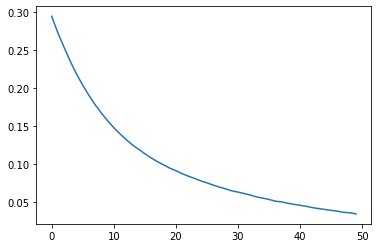

In [8]:
plt.plot(history)